In [5]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sm
from matplotlib import pyplot as plt
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
wine = pd.read_csv('Random-Forest-from-Scratch-master/winequality-red.csv', header=0)

### распределение экспертных оценок вин в выборке:

Text(0.5, 0, 'Quality')

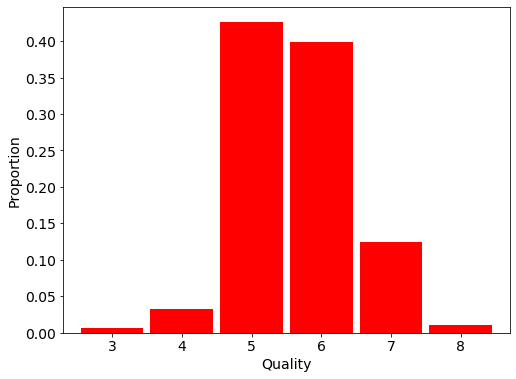

In [76]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

In [32]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [33]:
wine.shape[1]

12

In [40]:
y = wine[['quality']]

In [41]:
X = wine.iloc[:, wine.columns != 'quality']

### Распеределение меток класса по каждому признаку

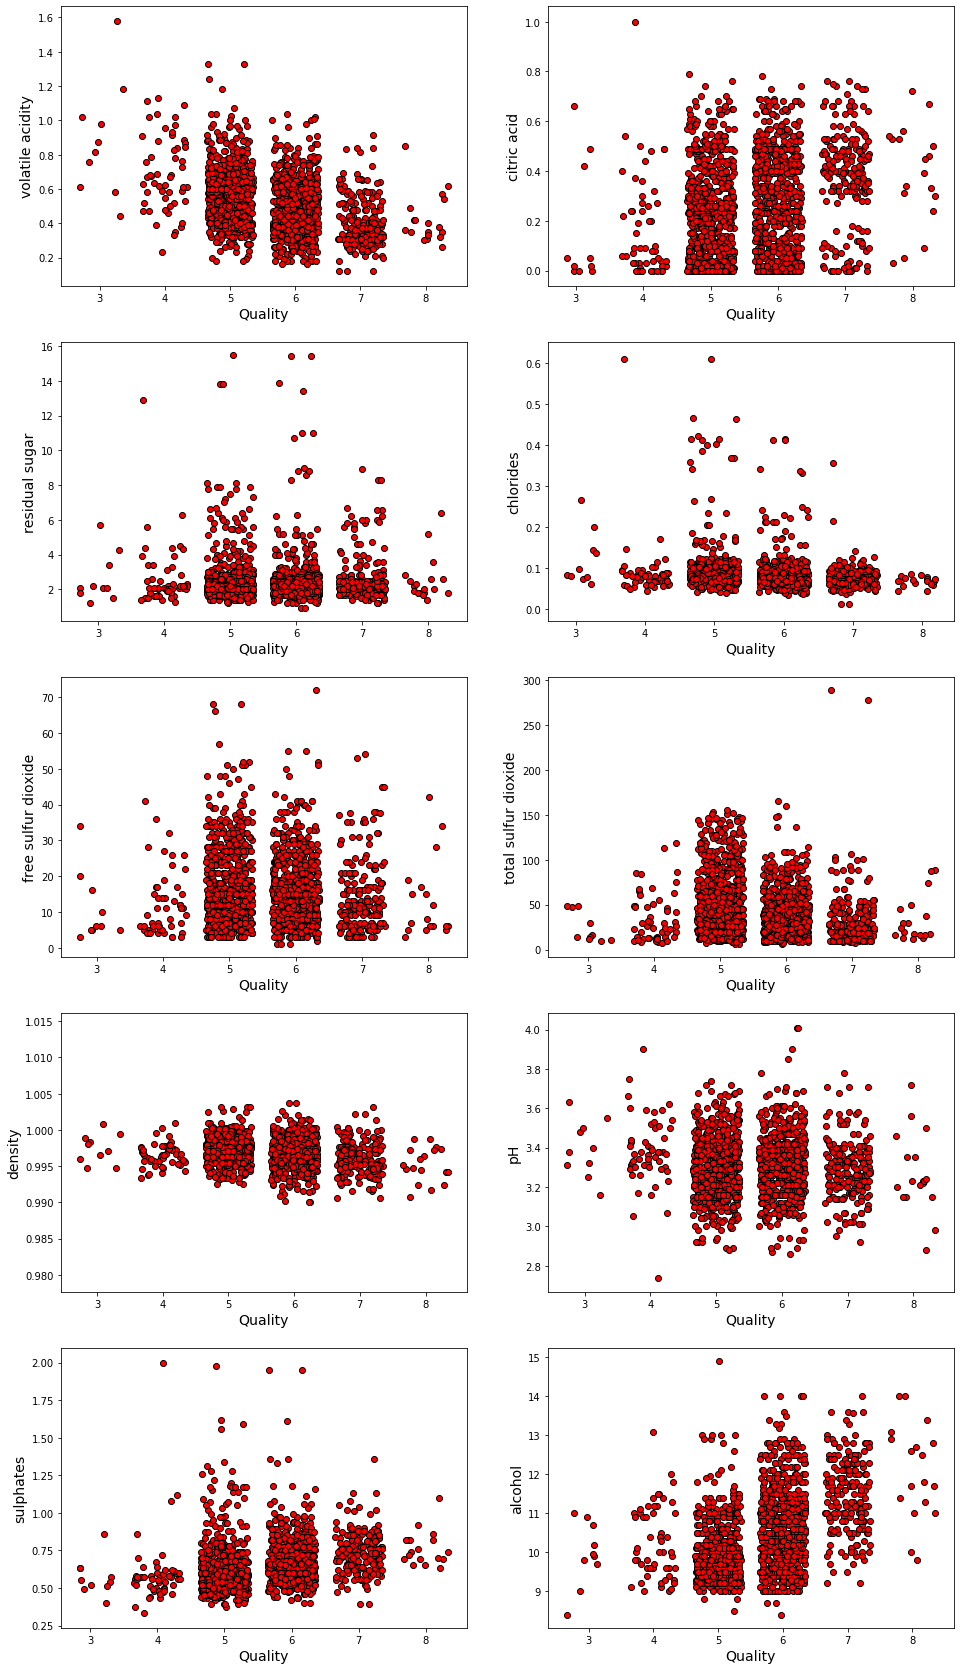

In [36]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, wine.shape[1] - 1):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.iloc[:, i], color = 'r', edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

### Проверка на наличие пропусков

In [43]:
pd.isnull(X).sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

### Гистограмы признаков

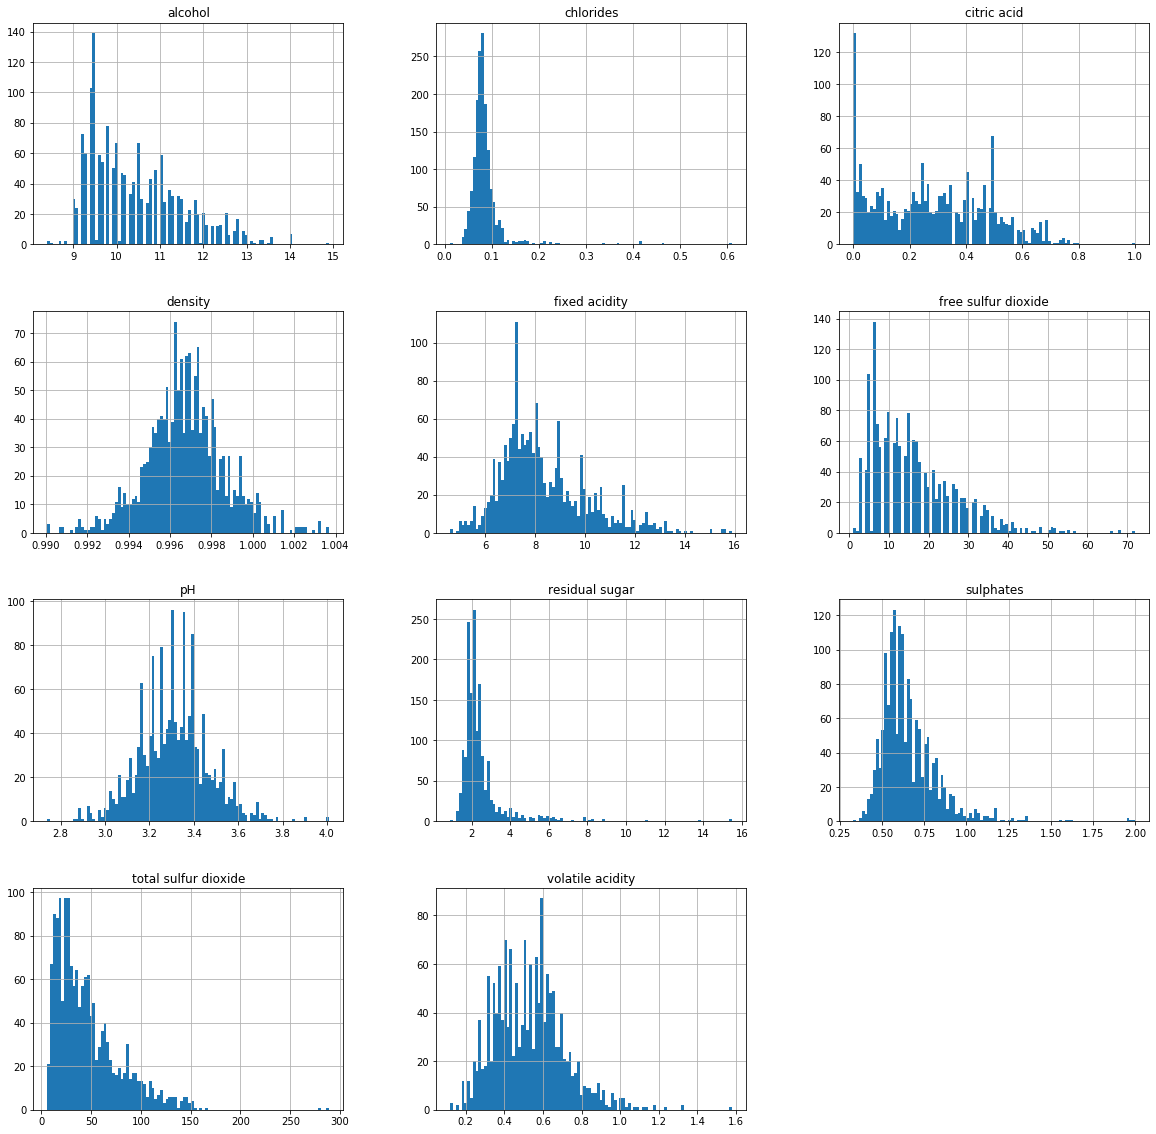

In [44]:
hist1 = X.hist(bins=100, figsize = (20, 20))

Eсть признаки с очень большим перекосом в сторону какого-то одного значения (например, total sulfur dioxide), возможно, их стоило бы прологарифмировать при решении задачи. Кроме того, есть признаки со сложной структурой гистограммы. 

В целом данные разнородны, и описать их одним вероятностным распределением непросто.

### Попарные признаки

Исключим признаки, распределение которых не похоже на колокол (хотя бы скошенный и неровный), тем самым мы уменьшим размер таблицы пар. На диагоналях таблицы будут стоять оценки распределений признаков (гистограммы или восстановленные плотности, diag_kind="hist" или "kde"). Если указать параметр hue = дискретный целевой признак, то разные его значения будут отображаться разными цветами.

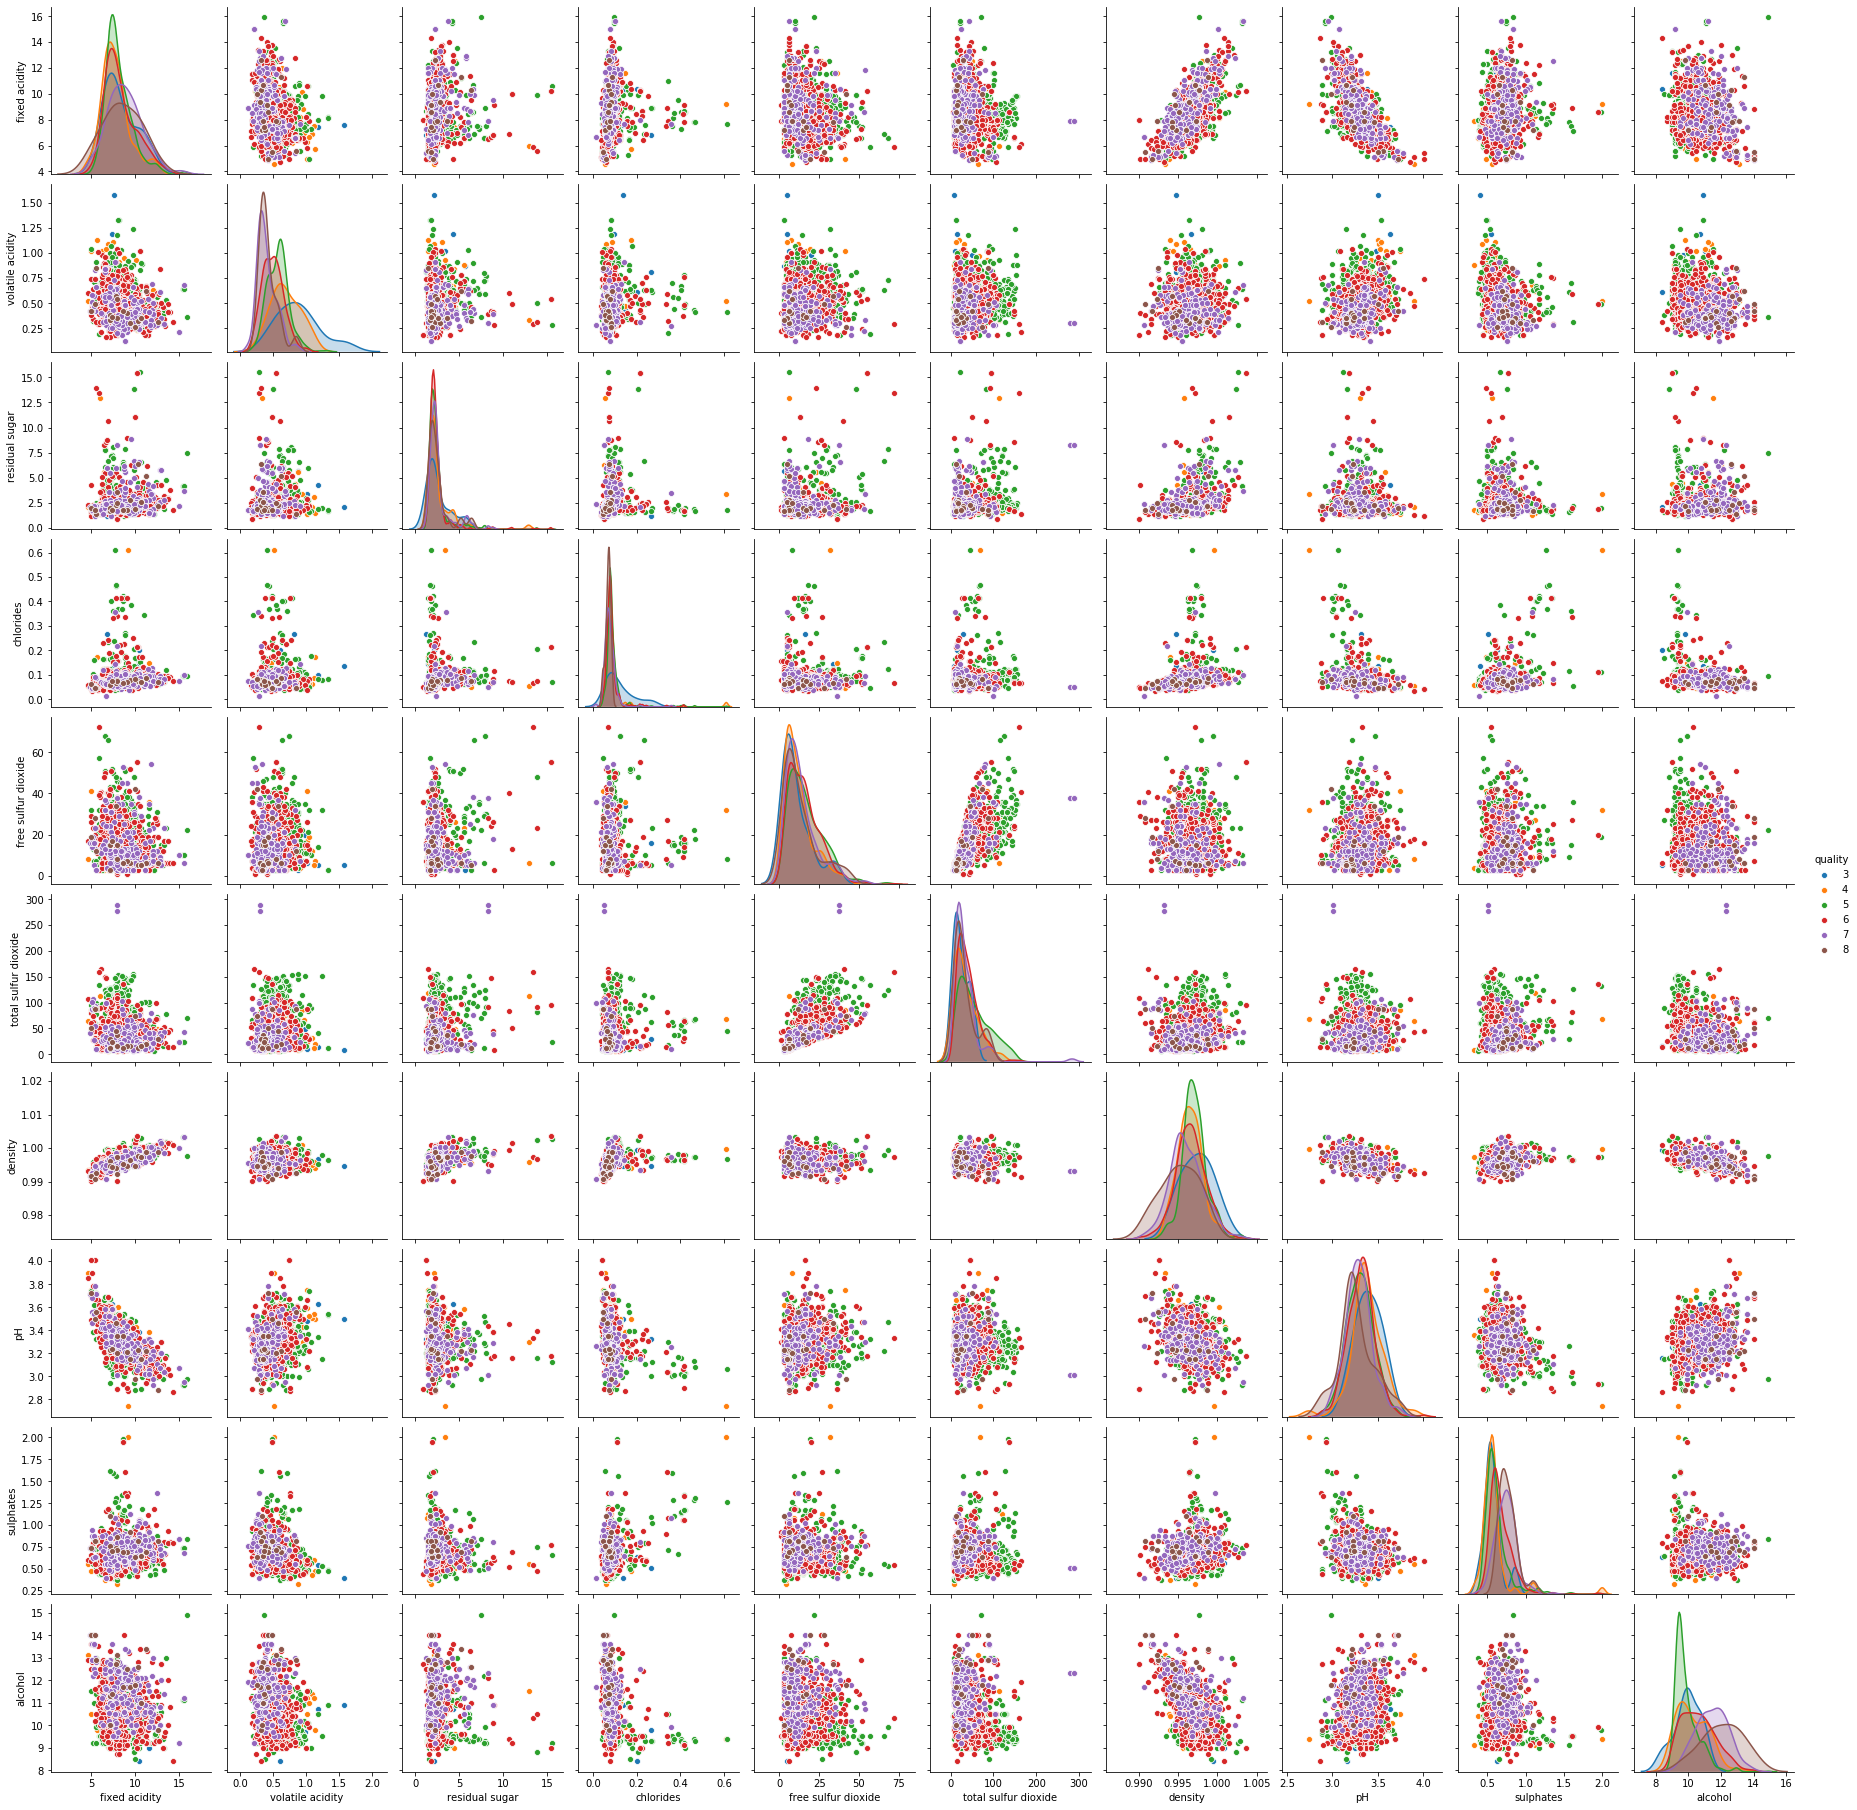

In [78]:
seaborn.pairplot(wine.drop(['citric acid'], axis = 1), 
        hue="quality", diag_kind="kde")

Классы накрывают друг друга, и графики не очень информативны. Но они позволяют ответить на некоторые вопросы о взаимоотношениях признаков и соотношений признаков и классов: есть выбросы и нет таких пар признаков, у которых облака точек разных классов отличаются

### Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед (гипотетическим) построением модели.


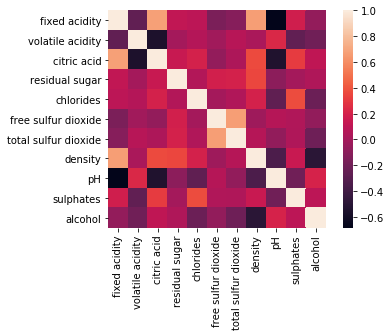

In [48]:
seaborn.heatmap(X.corr(), square=True)

In [49]:
X.corr() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


Видно, что нет (несовпадающих) признаков, корреляция между которыми больше 0.9 

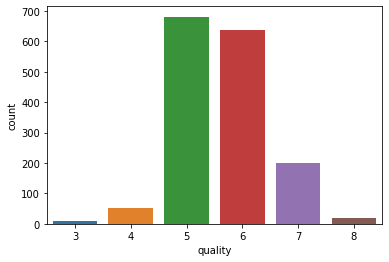

In [53]:
seaborn.countplot(wine.quality)

Видно, что выборка несбалансирована, поэтому в рамках лабораторной работы приведем к бинарному классу (если оценка <= 5, будем считать 0; иначе - 1)

In [64]:
df = wine


column_names = []
for column in df.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
df.columns = column_names

def transform_label(value):
    if value <= 5:
        return 0
    else:
        return 1

df["quality"] = df.quality.apply(transform_label)

In [65]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Text(0.5, 0, 'Quality')

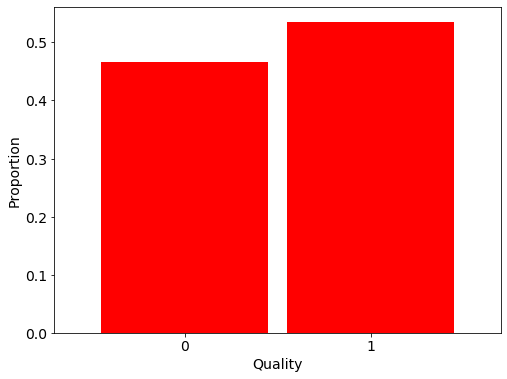

In [66]:
plt.figure(figsize(8,6))
stat = df.groupby('quality')['quality'].agg(lambda x : float(len(x))/df.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

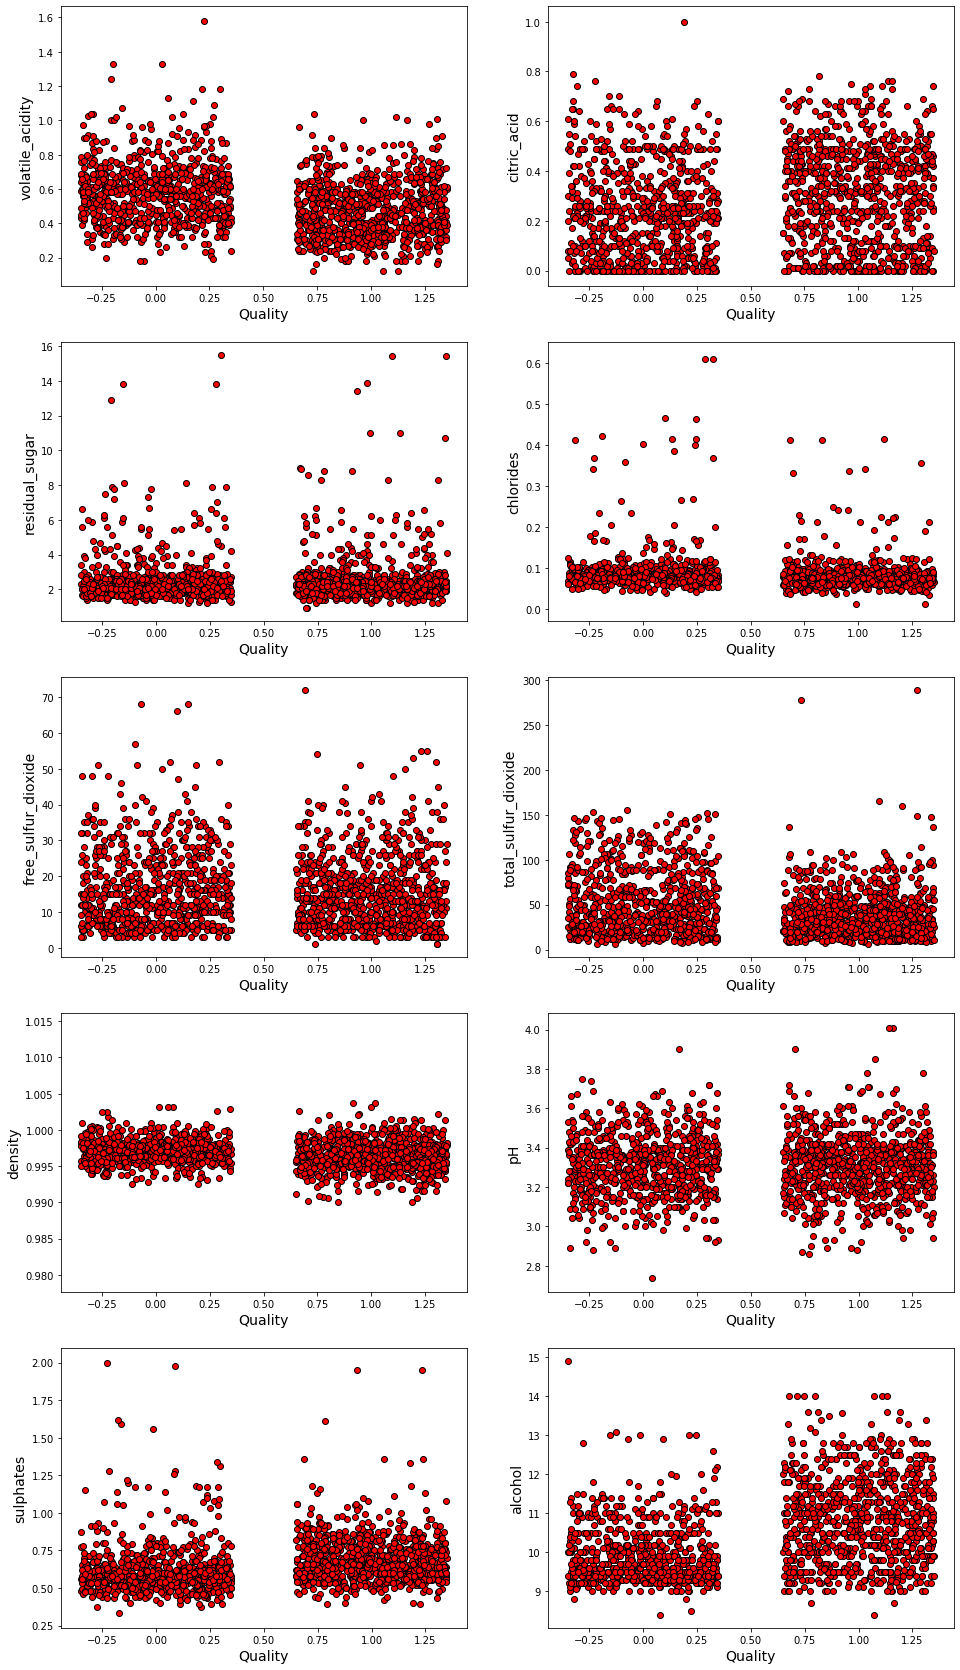

In [67]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, df.shape[1] - 1):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(df['quality']), df.iloc[:, i], color = 'r', edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(df.columns[i]), fontsize=14)

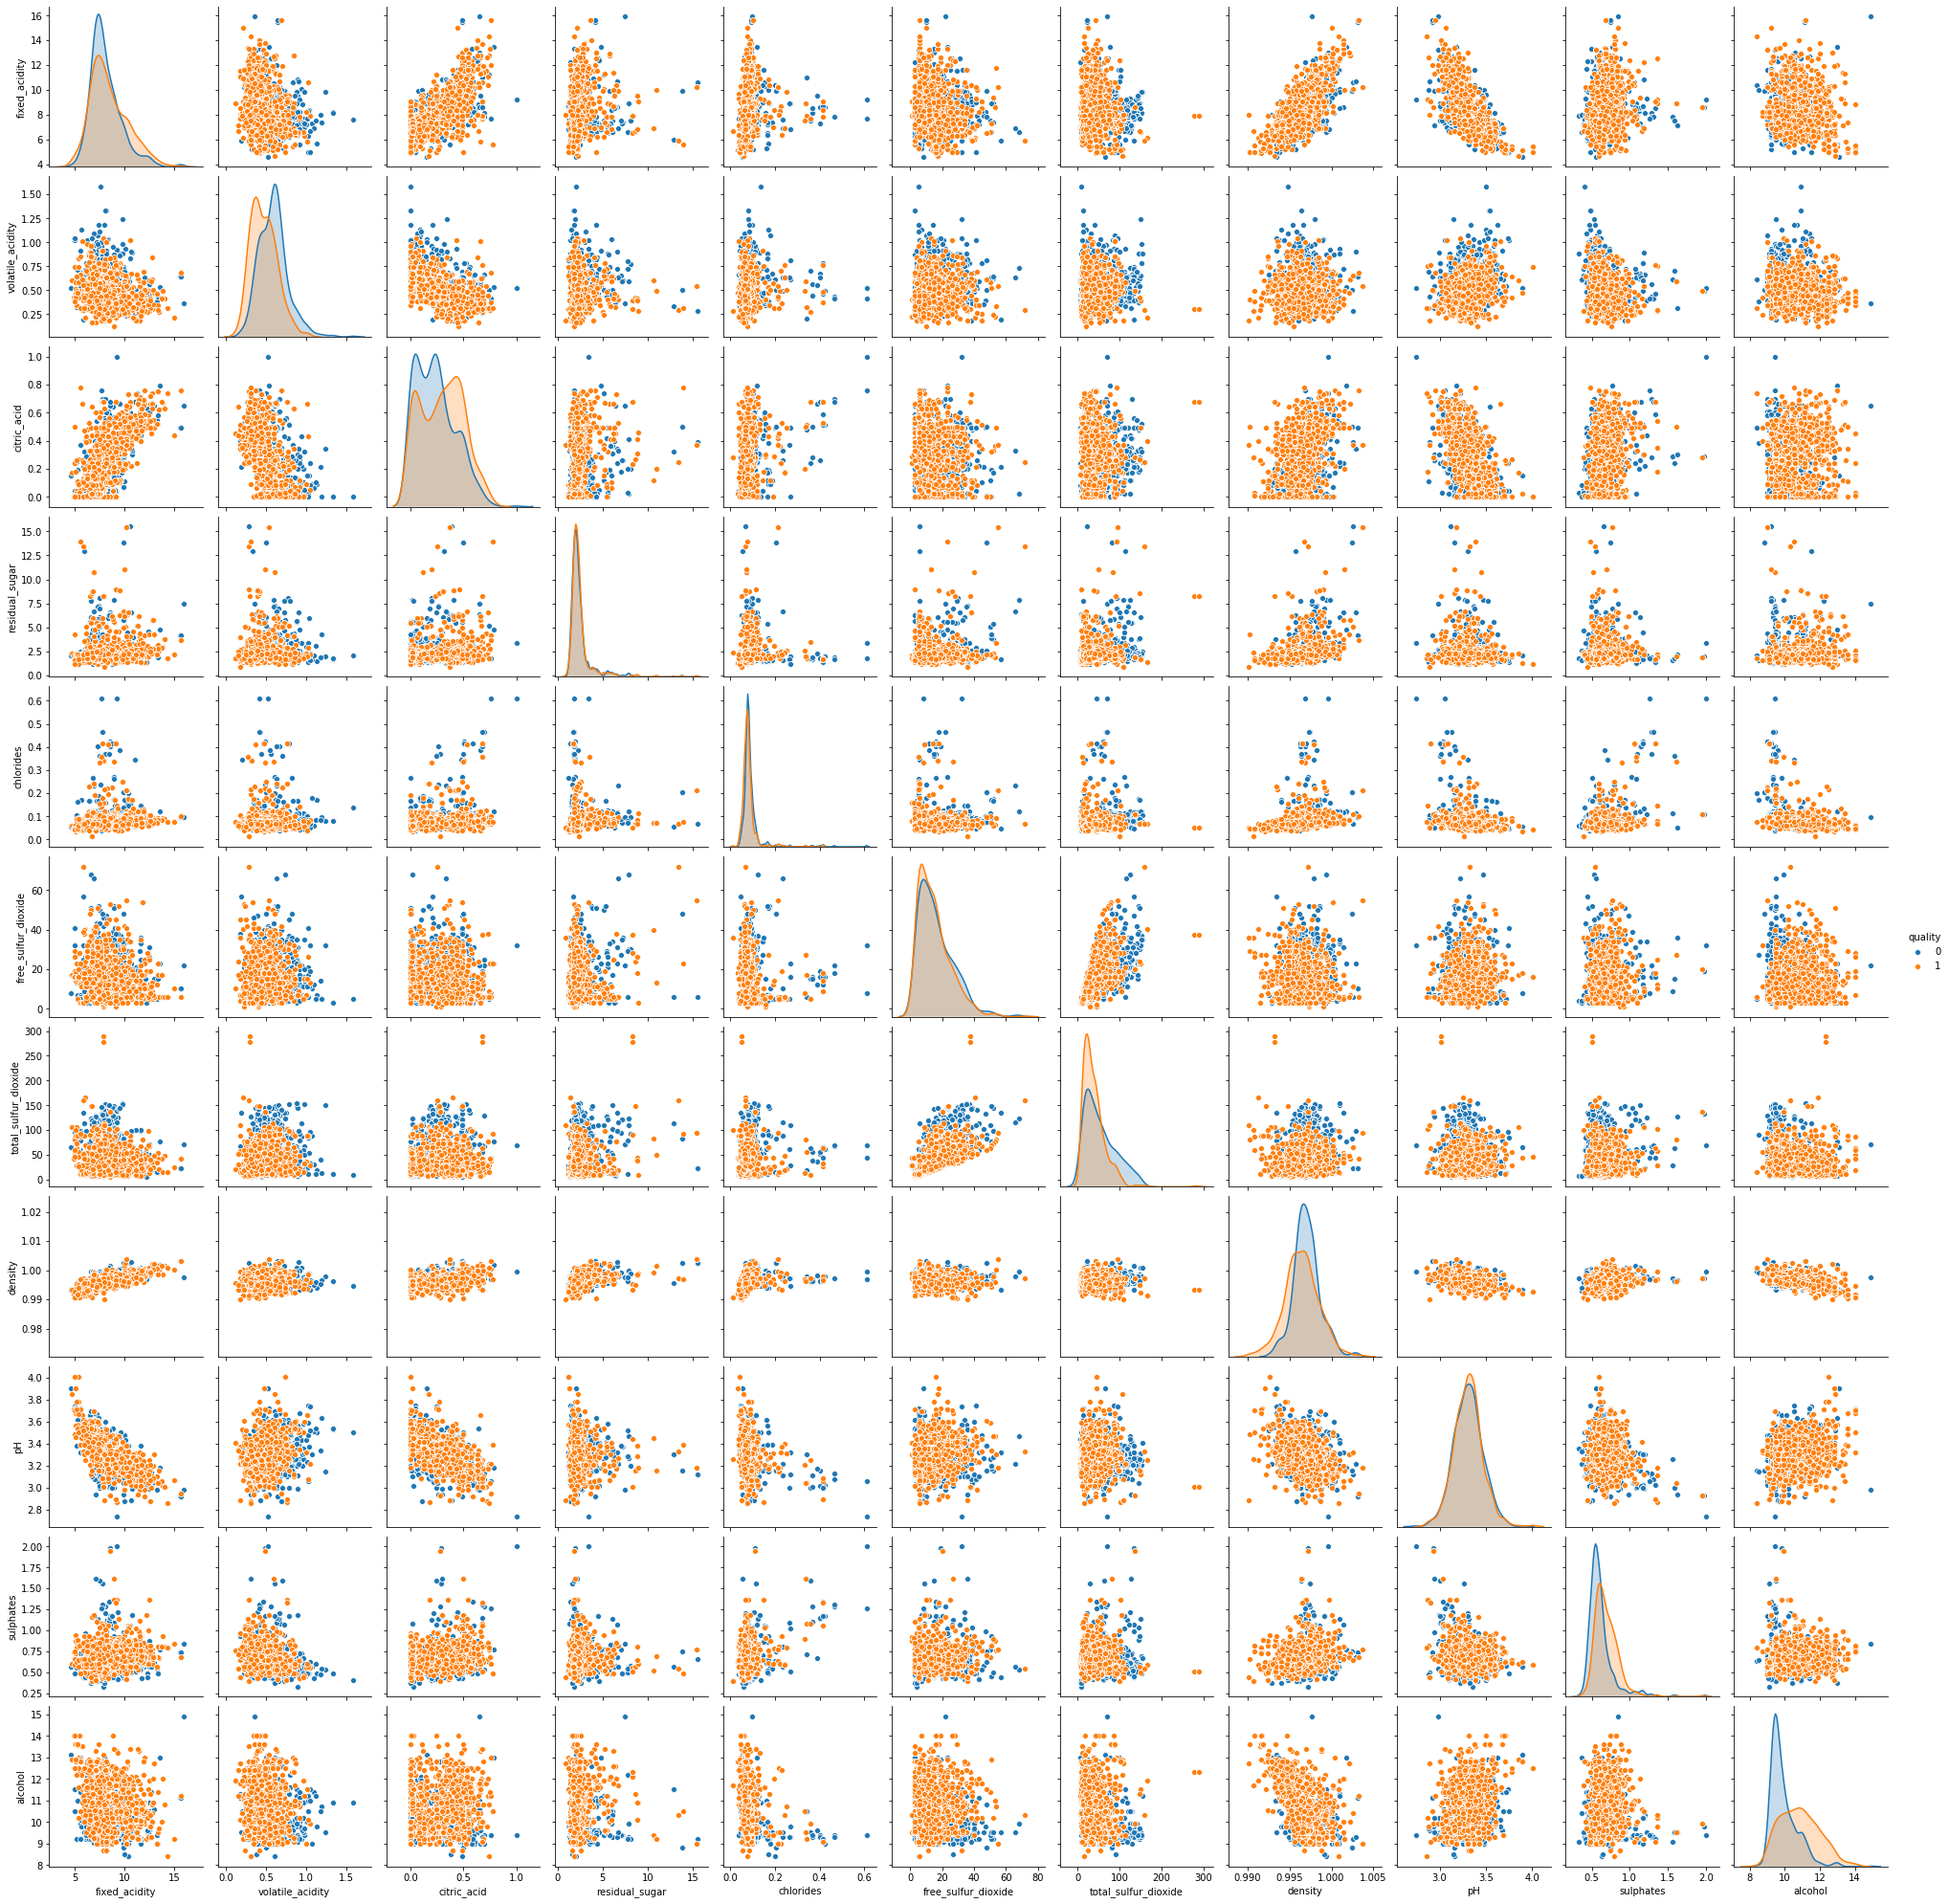

In [68]:
seaborn.pairplot(df, 
        hue="quality", diag_kind="kde")

все предыдущие выводы верны и сейчас

In [29]:
ins = pd.read_csv('insurance.csv', header=0)

In [7]:
ins.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
ins.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [9]:
ins.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

переведем категориальные признаки в бинарные для использования алгоритмов МЛ

In [30]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
ins = ins.join(pd.DataFrame(onehotencoder.fit_transform(ins[['sex']]).toarray(), columns=onehotencoder.categories_[0]))
#ins = ins.join(pd.DataFrame(onehotencoder.fit_transform(ins[['smoker']]).toarray(), columns=onehotencoder.categories_[0]))
ins = ins.join(pd.DataFrame(onehotencoder.fit_transform(ins[['region']]).toarray(), columns=onehotencoder.categories_[0]))
ins = ins.drop(['sex', 'region'], axis = 1)

In [31]:
booleanDictionary = {'yes': 1, 'no': 0}
ins['smoker'] = ins['smoker'].replace(booleanDictionary)

In [36]:
ins.head()

,age,bmi,children,smoker,charges,female,male,northeast,northwest,southeast,southwest
0,19,27.900,0,1,16884.92400,1.0,0.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0,1725.55230,0.0,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0,4449.46200,0.0,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0,21984.47061,0.0,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0,3866.85520,0.0,1.0,0.0,1.0,0.0,0.0


In [52]:
X = ins.iloc[:, ins.columns != 'charges']
y = ins[['charges']]

Распределения признаков:


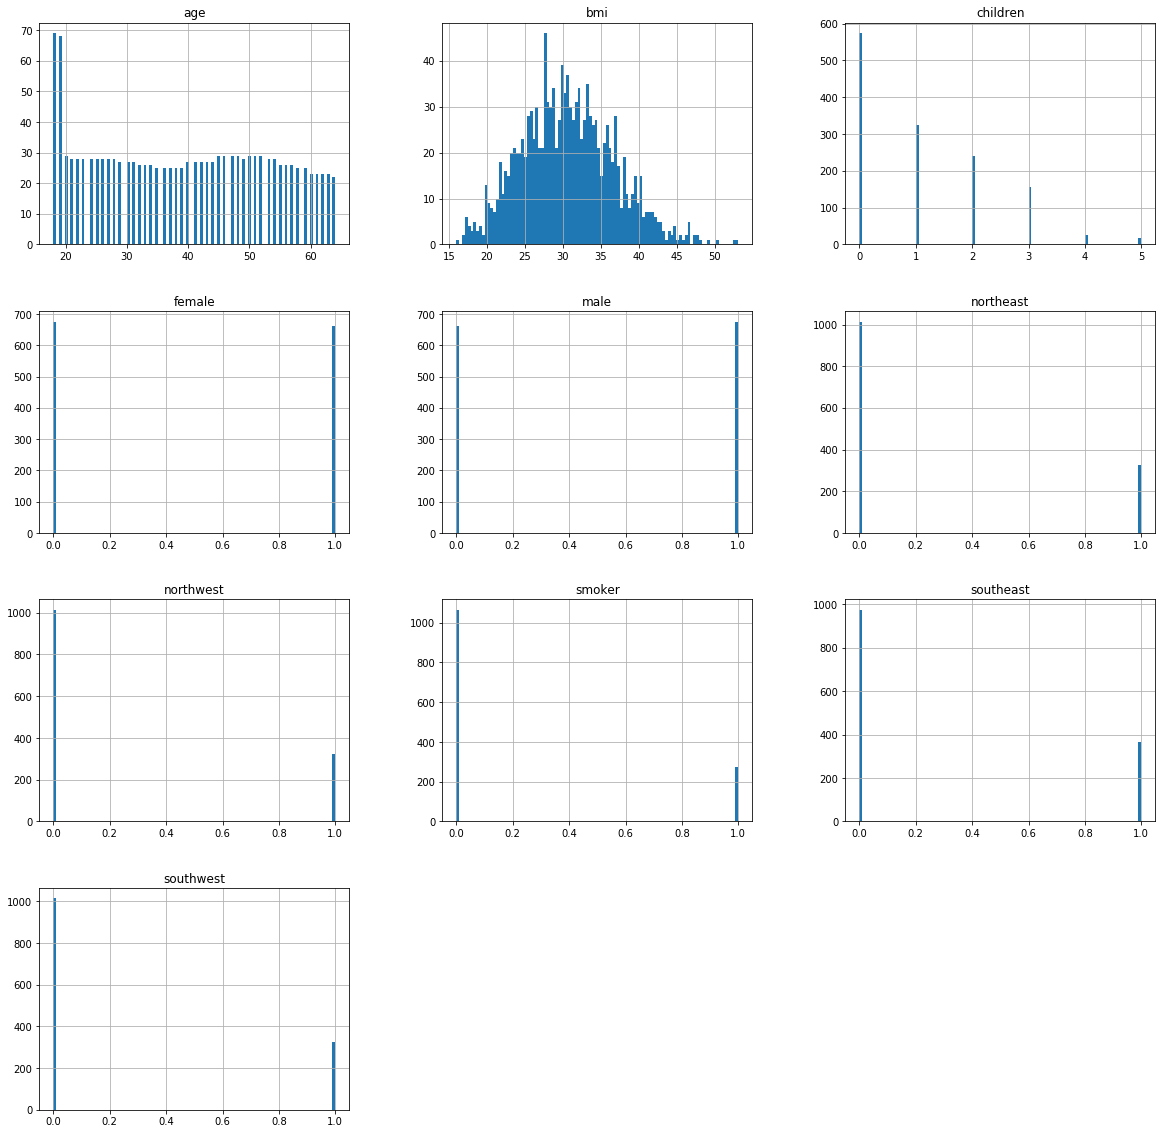

In [38]:
hist1 = X.hist(bins=100, figsize = (20, 20))

Все признаки дискретные, кроме `bmi` - он вещественный с распределением, близким к нормальному


In [45]:
ins.corr()['charges'].sort_values()

female      -0.057292
southwest   -0.043210
northwest   -0.039905
northeast    0.006349
male         0.057292
children     0.067998
southeast    0.073982
bmi          0.198341
age          0.299008
smoker       0.787251
charges      1.000000
Name: charges, dtype: float64

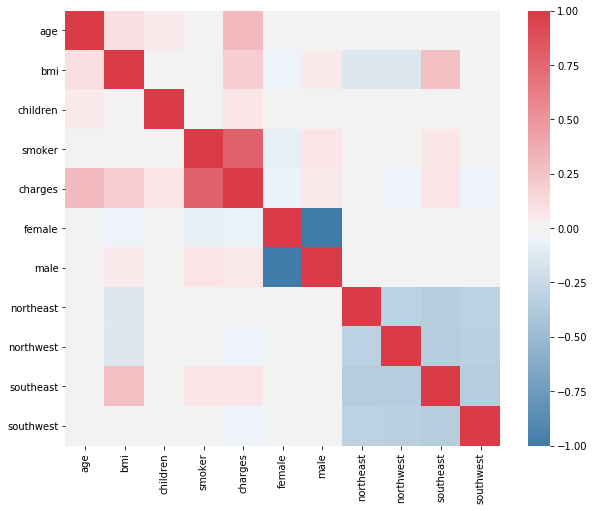

In [50]:
f, ax = plt.subplots(figsize=(10, 8))
corr = ins.corr()
seaborn.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=seaborn.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

очень информативная карта. Видно, что очень сильная зависимость целевого признака от `smoker`. А он, в свою очередь, больше коррелирует с мужским полом, нежели с женским, из чего можно сделать вывод, что затраты больше именно у курящих мужчин. Так же видно неплохую зависимость от возраста и `bmi`. Посмотрим на графики

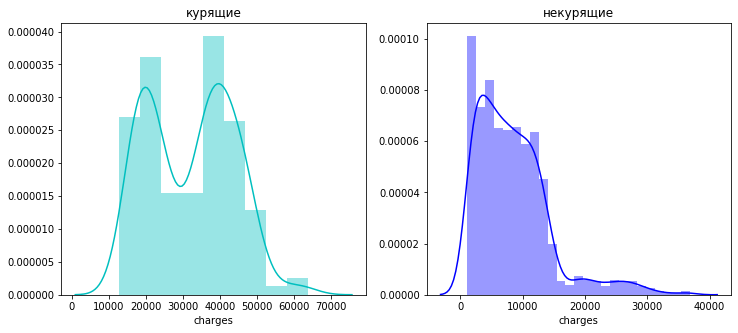

In [63]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
seaborn.distplot(ins[(ins.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('курящие')

ax=f.add_subplot(122)
seaborn.distplot(ins[(ins.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('некурящие')
plt.show()

Text(0.5, 1, 'bmi')

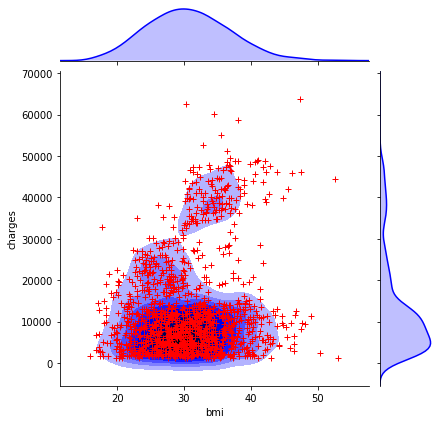

In [81]:
g = seaborn.jointplot(x="bmi", y="charges", data = ins,kind="kde", color="b")
g.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
ax.set_title('bmi')

Text(0.5, 1, 'возраст')

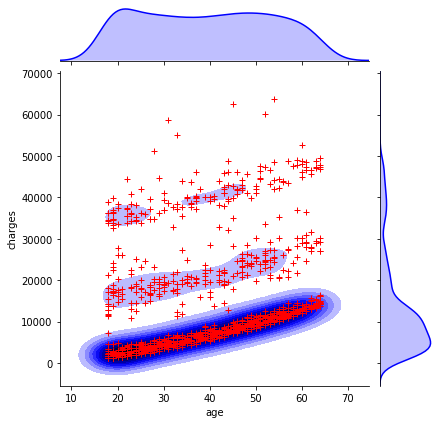

In [80]:
g = seaborn.jointplot(x="age", y="charges", data = ins,kind="kde", color="b")
g.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)

ax.set_title('возраст')

Распределение целевого признака:

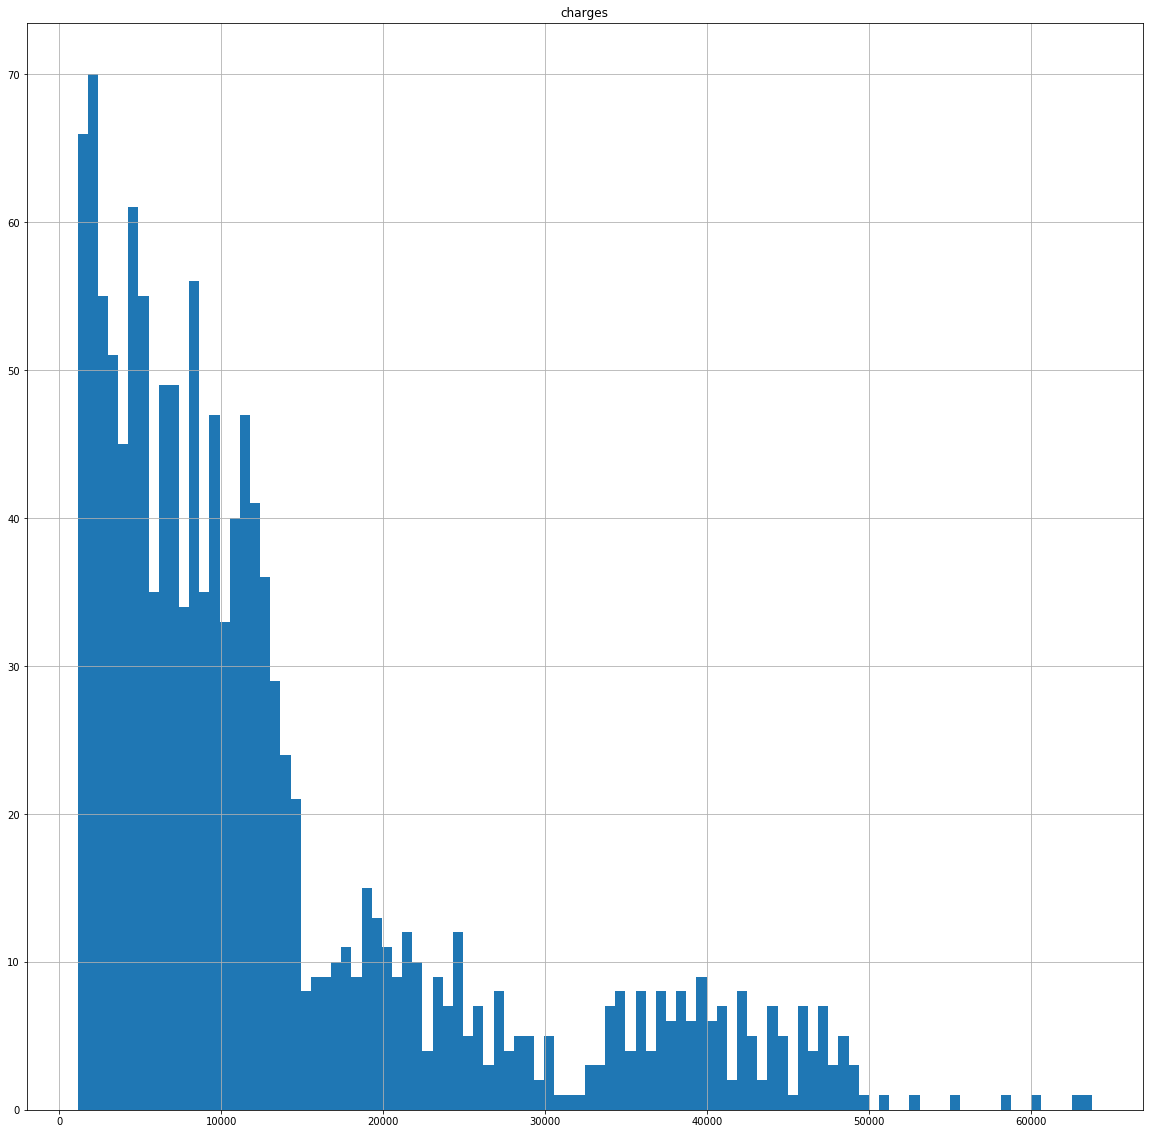

In [53]:
hist2 = y.hist(bins=100, figsize = (20, 20))

Попробуем решить с помощью Обычной линейной регрессии и РФ:

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor


x_train,x_test,y_train,y_test = train_test_split(X, y, random_state = 0)
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(lr.score(x_test,y_test))

0.7958786376014413


In [90]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


R2 train data: 0.974, R2 test data: 0.876
